Neural networks are powerful models that can be used to identify complex hidden patterns in data. There are many types of neural networks, two of which we have seen already on this blog: the vanilla, feed-forward neural network and convolutional neural networks, often abbreviated as convnets. Today, we will add a third kind to this exciting mix: recurrent neural networks, or RNNs. Let's take a brief conceptual look at how recurrent neural networks work, then implement a toy RNN to see how it compares to other models on the IMDB movie reviews dataset. I heavily borrowed my examples from [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python) by François Chollet and the [tutorial](https://www.tensorflow.org/tutorials/keras/text_classification_with_hub) on text classification available from the official TensorFlow documentation.

# Structure of Recurrent Neural Networks

Recurrent neural networks, as the name implies, refer to neural network models that contain some sort of internal looping structure that simulates a flow of information. A good way to conceptualize this loop is to think of something like `for` loops, where a certain operation is performed repeatedly for a specified number of cycles. Given these pieces of information, we might ask ourselves two questions. Firstly, what does this looping operation involve? Secondly, what is the purpose of having this loop in the first place? Let's try to answer both questions in the following subsections.

## Motivation

One of the most salient features of a recurrent neural network is that it is capable of emulating some primitive form of memory. Why might we want to do this? Well, take the example of reading a text. When we read, we don't process a given text at once in its totality; instead, we break them down into pieces, such as a word or a bag of words, and build our undestanding based on information obtained from the previous sequence of text. In other words, processing information through reading is at best understood as a process of continuously receiving new information while retaining information obtained from the previous sequence. This is why recurrent neural network models are frequently employed in the context of natural language processing.

But the applciations of RNNs extends beyond the domain of NLP. For example, say we are given a dataset of temperature recording of a city district. Obviously, the structural integrity of that dataset is very important, *i.e.* we should not shuffle the datasets because making weather predictions requires us to understand temporal patterns. In predicting the weather 24 hours from today, data points pertaining to the last two days will be obviously much more important that those recorded a month ago. In such instances of time series analysis, recurrent neural networks perform better than other models we have looked at thus far.

## Simple Implementation

To better understand how RNNs work, let's try to build a very simple recurrent neural network from scratch with `numpy`. We will only implement forward propagation for the sake of simplicity,  but with some matrix calculus, one can imagine how deriving the formula for back propagation will be possible. 


In [0]:
import numpy as np

Let's cut to the chase: RNNs emulate memory by using the output from the previous sequence as an input to the next. Perhap writing this down in matrix notation might give you a better idea of what the statement above means. Here is one way we might implement a very simple recurrent neural network.

$$y_t = \tanh(W x_t + U y_{t - 1} + b)$$

If the word "recursion" pops up into your mind, then you are on the right track. Notice that in calculating $y_t$, the output of the current sequence, the output of the previous sequence, $y_{t - 1}$ is used. By using the output of the previous sequence, the recurrent neural network is able to "remember" some of the information that was produced by the previous input. Granted, this is not exactly what memory is or how it works in the strictest sense, but we can see how some information from the previous input is trickling down to affect the computation of the current sequence of input data. Note that I used $\tanh$ for the example, but we can just about use any other activation function.

Here is one way we might implement this in Python. Although not necessary, I decided to opt for a class-based implementation to make things look tight and nicer.


In [0]:
class DummyRNN():

  def __init__(self, input_features, output_features):
    self.W = np.random.random((output_features, input_features))
    self.U = np.random.random((output_features, output_features))
    self.b = np.random.random((output_features,))
    self.state = np.zeros(output_features)

  def forward(self, input_data, concatenate):
    memory = []
    for input_t in input_data:
      output_t = np.tanh(self.W @ input_t + self.U @ self.state + self.b)
      memory.append(output_t)
      self.state = output_t
    if concatenate:
      result = np.concatenate(memory, axis=0)
    else:
      result = memory
    return result

Let's create a `DummyRNN` class object to see that everything works properly. 

In [13]:
time_steps = 100
input_features = 32
output_features = 64

model = DummyRNN(input_features, output_features)
dummy_input = np.random.random((time_steps, input_features))
len(model.forward(dummy_input, concatenate=True))

6400

There is really not much point in seeing the output because the calculations are going to be based off of randomly generated data and randomly created weights, but perhaps there is something to be learned from the dimensionality of input and output data. First, note that our model accepts input of size `(time_steps, input_features)`. The dimensionality of the output is a little more tricky becasue of the `concatenate` option. What concatenate does is that it basically flattens all `time_steps` number of outputs into a single list. In this case, because we set the option to `True`, we get a flattened list containing `time_steps * output_features`, or 6400 elements. 

The main takeaway is that recurrent neural networks can be used to implement some sort of memory functionality, which is useful when dealing with datasets where there exists some sort of sequential structure. One way to implement memory is by using the output of the previous sequence to define a `state` variable, which is used to compute the next output as we have done above. 

# Implementation with TensorFlow

Now let's get down to business with the `tensorflow.keras` API. Implementing a recurrent neural network is not so much different from building a simple feed forward or convolutional neural network: we simply import a RNN-specific layer and arrange these layers to construct a working model. 

Before we proceed any further, let's first import all necessary dependencies for this tutorial.

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras import preprocessing
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('seaborn')

## Data Preparation

As with any tutorial, we need to start by loading and preprocesisng data. Luckily, there isn't going to be much preprocessing involved since we will be using a dataset available from the `tensorflow.keras.datasets` library, the [IMBD movie reviews dataset](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb). The dataset contains 25,000 movie reviews from IMDB, labeled as either positive or negative. Each review is encoded as a sequence of integers according to a consistent encoding scheme. In other words, each integer corresponds to a unique word in the vocabulary of the dataset. More specifically, the integer to which a word is mapped corresponds to the frequency with which the word appears, *i.e.* the word encoded as 10 corresponds to the 10th most frequent word in the data. 

We will apply some very basic preprocessing on the dataset so that we can feed it into our model. Specifically, we will preprocess the datasete such that only a `max_features` number of most frequently occuring words are considered. This step will weed out words that occur very infrequently, thus decreasing the amount of noise from the network's perspective. Next, we will apply padding to the dataset so that all reviews are of length `max_len`. This means that longer reviews will be truncated, whereas shorter reviews will be padded with zero entries. Below is a sample code implementation of this process.


In [0]:
def load_data(max_len, max_features):
  (X_train, y_train), (X_test, y_test) = imdb.load_data(max_features)
  X_train = preprocessing.sequence.pad_sequences(X_train, max_len) 
  X_test = preprocessing.sequence.pad_sequences(X_test, max_len) 
  return X_train, y_train, X_test, y_test

Let's load the data using the `load_data` function after specifying necessary parameters.

In [0]:
max_len = 100
vocab_size = 1000
X_train, y_train, X_test, y_test = load_data(max_len=max_len, max_features=vocab_size)

Now that the data is here and ready to go, it's time to  build our neural network.

## Model Construction

To spice things up a bit, let's create four different models and compare their performance. Before we jump into that, however, we first need to understand what an embedding layer is, as it is key to natural language processing. 

### Embeddinng Layer

Simply put, an embedding layer is a layer that transforms words or integers that encode worrds into dense vectors. This is a necessary transformration since neural networks are incapable of dealing with non-quantitative variables. 

Why dense vectors, then? Can't we simply use one-hot encoding? That is a valid point, since one-hot encoding is how we mostly deal with categorical variables in a dataset. However, one downside of this approach is that we end up with many sparse vectors. In other words, a lot of resources are wasted because the model now has to process vectors of thousands or millions of dimensions, depending on the vocabulary size. Instead of using sparse vectors to represent each word, we can simply use a denser vector of smaller dimensions to encode our data. 

Another advantage of this approach is that dense vectors can be used to encode semantic information. You might have heard of the famous example that "king minus male equals queen minus female." If we were to represent the words king, queen, male, and female as vectors, we can add and subtract vectors to represent and distill meaningful information. This vector-based computation is the key to natural language processing with deep neural networks: by back propagating and adjusting the weights of our embeddeing layer, our model can eventually be trained to "understand" the meaning of words and their relationship with other words in the form of dense vectors.

Enough talking, let's use the embedding layer to build our neural networks, starting with the simple feed-forward model.

### Feed-Forward Model

The feed-forward neural network model will first have an embedding layer that processes input. Then, the output of this embedding layer will be flattened to be passed onto a dense layer with one output transforrmed by the sigmoid activation function. We use the sigmoid function since we want to conduct a sentiment analysis of determining whether a given movie review is postivie or negative. 

In [0]:
def feed_forward(vocab_size, output_dim, input_length):
  main_input = Input(shape=(input_length), dtype='int32')
  x = Embedding(input_dim=vocab_size, output_dim=output_dim, input_length=input_length)(main_input)
  x = Flatten()(x)
  output = Dense(1, activation=tf.nn.sigmoid)(x)
  model = Model(main_input, output)
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

That wasn't so difficult. Let's initalize our model by defining the model parameters `vocab_size`, `output_dim`, and `input_length`, then plot the model to see the structure of the network alongside the input and output dimensions of each layer. Note that we defined `output_dim` to be 16, which means that each word is transformed into dense vectors living in 16 dimensions.

In [0]:
model_1 = feed_forward(vocab_size, 16, max_len)

By plotting the model, we can get a better idea of the layers that compose the model.

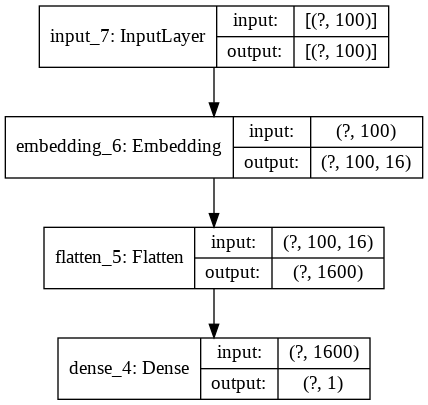

In [0]:
plot_model(model_1, show_shapes=True, show_layer_names=True)

### Recurrent Neural Network

The next model we will build is a simple recurrent neural network. This neural network is going to have an embedding layer, just like the previous model. However, instead of a dense layer, it will have two consecutive `SimpleRNN` layers stacked on top of each other. The `SimpleRNN` layer is essentially the `tf.keras` implementation of the `DummyRNN` model we built earlier. Let's take a look.

In [0]:
def simple_rnn(vocab_size, output_dim, input_length):
  main_input = Input(shape=(input_length), dtype='int32')
  x = Embedding(input_dim=vocab_size, output_dim=output_dim, input_length=input_length)(main_input)
  x = SimpleRNN(32, return_sequences=True)(x)
  x = SimpleRNN(32)(x)
  output = Dense(1, activation=tf.nn.sigmoid)(x)
  model = Model(main_input, output)
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

We instantiate the model and take plot the network, just as we have done above.

In [0]:
model_2 = simple_rnn(vocab_size, 16, max_len)

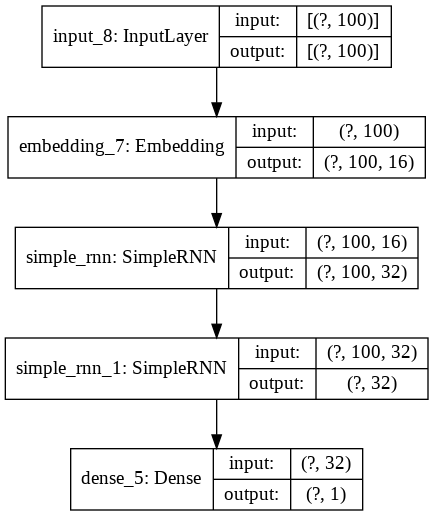

In [0]:
plot_model(model_2, show_shapes=True, show_layer_names=True)

### Long Short-Term Memory Model

The `simple_rnn` model we built is, as the name shamelessly puts out, pretty simple. There are a lot more advanced recurrent neural networks that have complicated internal cell structures to better emulate human memory, in a sense. The biggest difference between a simple recurrent neural network and an LSTM is that LSTMs have a unique parameter known as the carrier that encodes an additional layer of information about the state of the cell. I might write a separate post devoted to the intricacies of the LSTM, but if you're an avid reader who's itching to know more about it right away, I highly recommend this excellent [post](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) by Christiopher Olah. For now, let's just say that LSTMs represent a huge improvement over conventional RNNs, and that we can implement them in `tf.keras` by simply calling the `LSTM` layer as shown below:

In [0]:
def simple_lstm(vocab_size, output_dim, input_length):
  main_input = Input(shape=(input_length), dtype='int32')
  x = Embedding(input_dim=vocab_size, output_dim=output_dim, input_length=input_length)(main_input)
  x = LSTM(32)(x)
  x = Dense(32, activation=tf.nn.relu)(x)
  x = Dropout(0.2)(x)
  output = Dense(1, activation=tf.nn.sigmoid)(x)
  model = Model(main_input, output)
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

Because LSTM layers take a lot longer to train than others, and because the representational capacity of a single LSTM layer is higher than that of others, I decided to use only one LSTM layer instead of two. Let's initialize this model to take a better look.

In [0]:
model_3 = simple_lstm(vocab_size, 16, max_len)

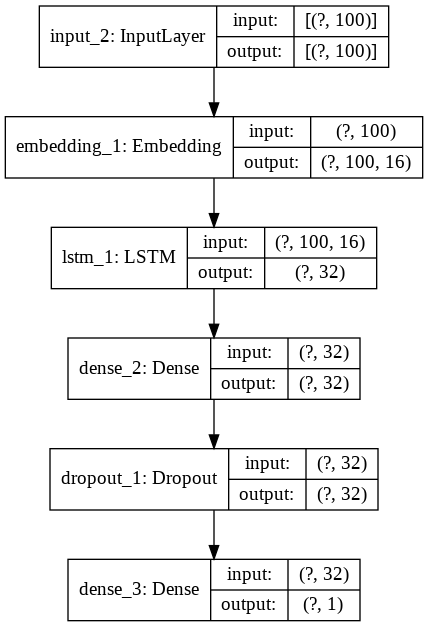

In [7]:
plot_model(model_3, show_shapes=True, show_layer_names=True)

The last model we will create is a convnet, which we explored on this previous [post](https://jaketae.github.io/study/cnn/) on image classification. Convolutional neural networks are great at identifying spatial patterns in data, which is why they also perform resonably well in natural language processing. Another huge advantage of convents over recurrent networks is that they took a lot lesser time and resources to train. This is why it is often a good idea to build a convent to establish a baseline performance metric. 

In [0]:
def simple_cnn(vocab_size, output_dim, input_length):
  main_input = Input(shape=(input_length), dtype='int32')
  x = Embedding(input_dim=vocab_size, output_dim=output_dim, input_length=input_length)(main_input)
  x = Conv1D(32, 7, activation=tf.nn.relu)(x)
  x = MaxPooling1D(5)(x)
  x = Conv1D(32, 7, activation=tf.nn.relu)(x)
  x = GlobalMaxPool1D()(x)
  output = Dense(1)(x)
  model = Model(main_input, output)
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

Let's initialize the model with identical parameters and take a look at its internal structure.

In [0]:
model_4 = simple_cnn(vocab_size, 16, max_len)

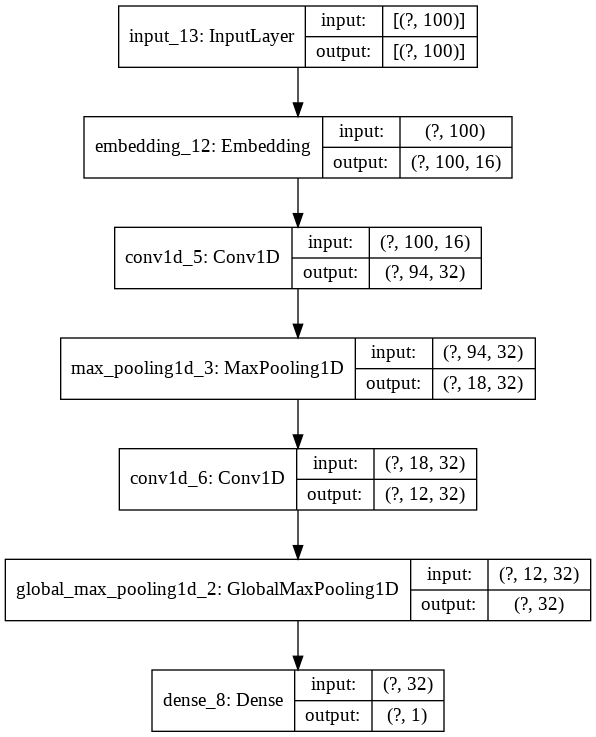

In [0]:
plot_model(model_4, show_shapes=True, show_layer_names=True)

## Model Training

Let's train all four models using the training data. For control our experiment, we will train all four models over the same `batch_size=32`, `epochs=10`, and `validation_split=0.2`. There isn't much exciting here to look at it terms of code; it's just a matter of patience, waiting for the models to hopefully converge to a global minimum. For future reference, all training history is dumped in the `history_n` object where `n` corresponds to the model number.

In [0]:
history_1 = model_1.fit(X_train, 
                        y_train, 
                        batch_size=32, 
                        epochs=10, 
                        validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 2s 119us/sample - loss: 0.2706 - acc: 0.8922 - val_loss: 0.3372 - val_acc: 0.8562
Epoch 2/10
20000/20000 [==============================] - 2s 121us/sample - loss: 0.2434 - acc: 0.9073 - val_loss: 0.3483 - val_acc: 0.8476
Epoch 3/10
20000/20000 [==============================] - 2s 118us/sample - loss: 0.2173 - acc: 0.9212 - val_loss: 0.3585 - val_acc: 0.8454
Epoch 4/10
20000/20000 [==============================] - 2s 116us/sample - loss: 0.1920 - acc: 0.9364 - val_loss: 0.3904 - val_acc: 0.8320
Epoch 5/10
20000/20000 [==============================] - 2s 112us/sample - loss: 0.1689 - acc: 0.9477 - val_loss: 0.3901 - val_acc: 0.8308
Epoch 6/10
20000/20000 [==============================] - 2s 109us/sample - loss: 0.1472 - acc: 0.9589 - val_loss: 0.4091 - val_acc: 0.8268
Epoch 7/10
20000/20000 [==============================] - 2s 115us/sample - loss: 0.1272 - acc: 0.9687 - val_lo

In [0]:
history_2 = model_2.fit(X_train, 
                        y_train, 
                        batch_size=32, 
                        epochs=10, 
                        validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 53s 3ms/sample - loss: 0.6252 - acc: 0.6412 - val_loss: 0.6472 - val_acc: 0.6328
Epoch 2/10
20000/20000 [==============================] - 53s 3ms/sample - loss: 0.6286 - acc: 0.6467 - val_loss: 0.6108 - val_acc: 0.6628
Epoch 3/10
20000/20000 [==============================] - 52s 3ms/sample - loss: 0.5302 - acc: 0.7362 - val_loss: 0.4725 - val_acc: 0.7834
Epoch 4/10
20000/20000 [==============================] - 52s 3ms/sample - loss: 0.4340 - acc: 0.8036 - val_loss: 0.4519 - val_acc: 0.7890
Epoch 5/10
20000/20000 [==============================] - 52s 3ms/sample - loss: 0.4045 - acc: 0.8242 - val_loss: 0.4529 - val_acc: 0.8108
Epoch 6/10
20000/20000 [==============================] - 53s 3ms/sample - loss: 0.3885 - acc: 0.8338 - val_loss: 0.4481 - val_acc: 0.7916
Epoch 7/10
20000/20000 [==============================] - 52s 3ms/sample - loss: 0.3751 - acc: 0.8381 - val_loss: 0.4

In [0]:
history_3 = model_3.fit(X_train, 
                        y_train, 
                        batch_size=32, 
                        epochs=10, 
                        validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 240s 12ms/sample - loss: 0.4866 - acc: 0.7538 - val_loss: 0.4188 - val_acc: 0.8148
Epoch 2/10
20000/20000 [==============================] - 240s 12ms/sample - loss: 0.3850 - acc: 0.8299 - val_loss: 0.3962 - val_acc: 0.8246
Epoch 3/10
20000/20000 [==============================] - 238s 12ms/sample - loss: 0.3667 - acc: 0.8375 - val_loss: 0.4108 - val_acc: 0.8102
Epoch 4/10
20000/20000 [==============================] - 239s 12ms/sample - loss: 0.3559 - acc: 0.8440 - val_loss: 0.3892 - val_acc: 0.8210
Epoch 5/10
20000/20000 [==============================] - 240s 12ms/sample - loss: 0.3410 - acc: 0.8505 - val_loss: 0.3856 - val_acc: 0.8216
Epoch 6/10
20000/20000 [==============================] - 249s 12ms/sample - loss: 0.3343 - acc: 0.8540 - val_loss: 0.4038 - val_acc: 0.8246
Epoch 7/10
20000/20000 [==============================] - 250s 12ms/sample - loss: 0.3257 - acc: 0.8574 -

In [0]:
history_4 = model_4.fit(X_train, 
                        y_train, 
                        batch_size=32, 
                        epochs=10, 
                        validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 8s 418us/sample - loss: 0.6473 - acc: 0.6470 - val_loss: 0.5372 - val_acc: 0.7466
Epoch 2/10
20000/20000 [==============================] - 2s 106us/sample - loss: 0.5667 - acc: 0.7542 - val_loss: 0.7262 - val_acc: 0.5218
Epoch 3/10
20000/20000 [==============================] - 2s 108us/sample - loss: 0.5669 - acc: 0.7245 - val_loss: 0.5634 - val_acc: 0.7370
Epoch 4/10
20000/20000 [==============================] - 2s 107us/sample - loss: 0.5552 - acc: 0.7383 - val_loss: 0.5574 - val_acc: 0.7634
Epoch 5/10
20000/20000 [==============================] - 2s 106us/sample - loss: 0.4822 - acc: 0.7847 - val_loss: 0.5535 - val_acc: 0.7614
Epoch 6/10
20000/20000 [==============================] - 2s 115us/sample - loss: 0.4619 - acc: 0.8069 - val_loss: 0.5387 - val_acc: 0.7730
Epoch 7/10
20000/20000 [==============================] - 2s 106us/sample - loss: 0.4385 - acc: 0.8191 - val_lo

In [0]:
history_5 = model_5.fit(X_train, 
                        y_train, 
                        batch_size=32, 
                        epochs=10, 
                        validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 85s 4ms/sample - loss: 0.4972 - acc: 0.7459 - val_loss: 0.4147 - val_acc: 0.8120
Epoch 2/10
20000/20000 [==============================] - 85s 4ms/sample - loss: 0.3874 - acc: 0.8345 - val_loss: 0.3996 - val_acc: 0.8206
Epoch 3/10
20000/20000 [==============================] - 85s 4ms/sample - loss: 0.3639 - acc: 0.8399 - val_loss: 0.3948 - val_acc: 0.8164
Epoch 4/10
20000/20000 [==============================] - 84s 4ms/sample - loss: 0.3483 - acc: 0.8497 - val_loss: 0.3963 - val_acc: 0.8160
Epoch 5/10
20000/20000 [==============================] - 84s 4ms/sample - loss: 0.3371 - acc: 0.8551 - val_loss: 0.3870 - val_acc: 0.8190
Epoch 6/10
20000/20000 [==============================] - 85s 4ms/sample - loss: 0.3271 - acc: 0.8566 - val_loss: 0.4170 - val_acc: 0.8064
Epoch 7/10
20000/20000 [==============================] - 84s 4ms/sample - loss: 0.3173 - acc: 0.8607 - val_loss: 0.3

## Model Evaluation

After a long time of waiting, the training is finally complete! If you are following this tutorial on your local workstation, please note that the time required for training may vary depending on your hardware configurations or the specification of our instance if you are using a cloud-based platform like AWS. 

None of our models reached the threshold of ninety percent accuracy, but they all managed to converge to some reasonable number, hovering around the high seventies to low eighties. Let's test the performance of our models by using the `X_test` and `y_test` data, both of which none of our models have seen before.

In [0]:
model_1.evaluate(X_test, y_test)

25000/25000 [==============================] - 1s 48us/sample - loss: 0.5968 - acc: 0.7931


[0.5968295060539246, 0.79312]

In [0]:
model_2.evaluate(X_test, y_test)

25000/25000 [==============================] - 14s 562us/sample - loss: 0.4948 - acc: 0.7911


[0.4948168795013428, 0.79112]

In [0]:
model_3.evaluate(X_test, y_test)

25000/25000 [==============================] - 24s 946us/sample - loss: 0.4092 - acc: 0.8321


[0.4091824066162109, 0.83212]

In [0]:
model_4.evaluate(X_test, y_test)

25000/25000 [==============================] - 1s 42us/sample - loss: 0.6494 - acc: 0.7915


[0.6493830096054077, 0.79152]

Based on the results, it looks like the LSTM model performed best, beating other models by a small margin. At this point, we cannot conclude as to whether or not this marginal boost in performance is significant. Judging this would not only depend on the context, but also most likely require us to have a larger test dataset that captures the statistics of the population data. This point notwithstanding, it is certainly beneficial to know that LSTM networks are good at detecting sequential patterns in data.

Last but not least, let's visualize the training scheme of all four models to take a identify any possible signs of convergence and overfitting, if any. To do that, we will be using the `show_learning_curve` function shown below.

In [0]:
def show_learning_curve(history):
  fig = plt.figure()
  plt.subplot(2,1,1)
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'])
  plt.subplot(2,1,2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Cross Entropy Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'])
  plt.tight_layout()
  plt.show()

The dense feed-forward network seems to have a very linear pattern. One immediate pattern we see is that the model seems to be overfitting right away, since the testing accuracy decreases with each epoch while the training accuracy increases. This is certainly not a good sign; in the best case scenario, we want to see that training and testing labels moving in the same direction. Perhaps this is the biggest indication that a simple feed forward network is a suboptimal model choice in the context of this problem.

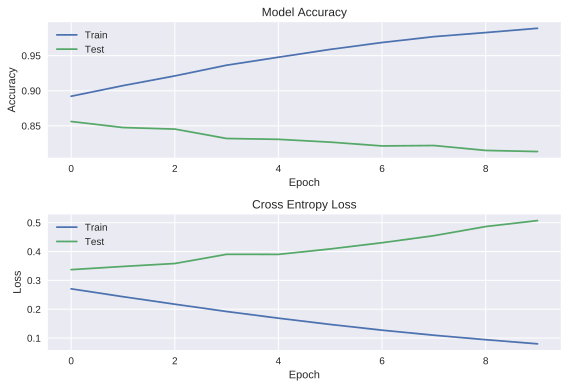

In [0]:
show_learning_curve(history_1)

The graphs for the `simple_rnn` model seems a lot better. At the very least, we see the training and test labels moving in unison: the accuracy increases with each epoch, while the loss slowly decreases. However, we do see some overfitting happening at the last two epochs or so. Specifically, note that cross entropy loss for the testing data seems to pick up an incrementing pattern past the seventh epoch. This observation suggests that we need to configure the model differently, presumably by decreasing the number of tunable parameters.

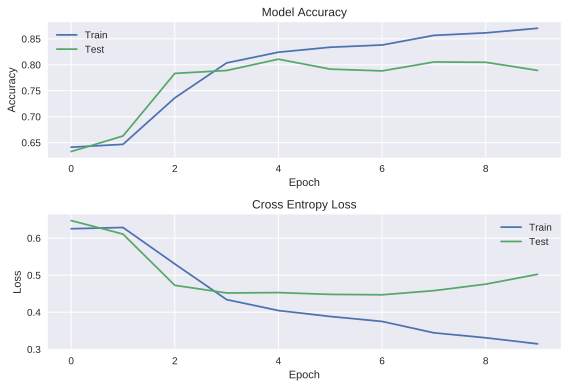

In [0]:
show_learning_curve(history_2)

Next comes the winner of the day, the LSTM network. An interesting point to note about the learning curve of this model is that the test data accuracy and loss seem to stay roughly stagnant despite the progression of epochs. To better understand this phenomena, we probaby have to run more trials with more data over longer iterations than we have done in this tutorial. This point notwithstanding, it is interesting to see how a single layer LSTM network can outperform a stacked RNN network. 

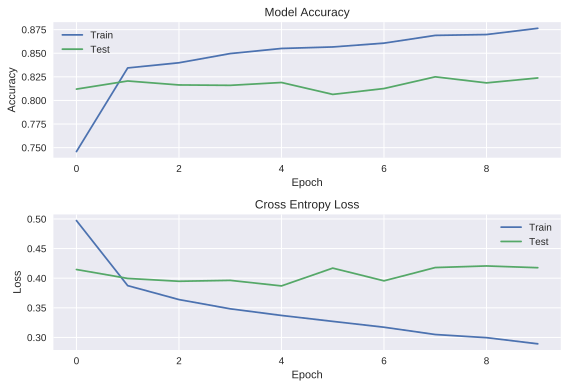

In [0]:
show_learning_curve(history_3)

The last up on this list is the one-dimensional convolutional neural network. The convent produced very remarkable results in this experiment, especially given its extremely short training time. Recurrent neural networks typically take a lot of time to train---even when they are not stacked---because each neuron is defined by a rather complicated operation involving many parameters, such as states, carriage, and so on. Convents, on the other hand, are relatively simpler, and thus take noticeably shorter to train and deploy. This tutorial demonstrates that convents can perform as well as simple recurrent networks to estabish a baseline performance metric. 

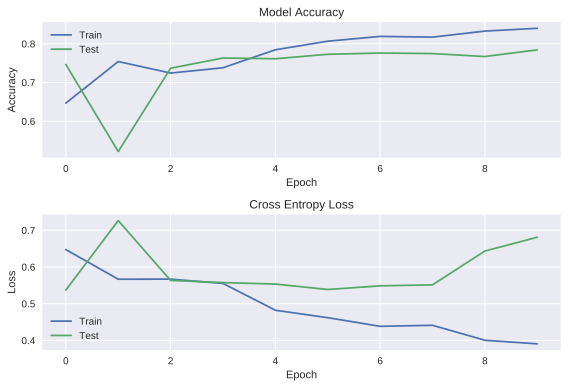

In [0]:
show_learning_curve(history_4)

# Conclusion

In this post, we briefly introduced and explored the concept of recurrent neural networks, how they work, and how to build them using the `tf.keras` functional API. Recurrent neural networks are one of the hottest topics in the contemporary deep learning academia because it presents numerous possibilities for applilcation. Hopefully this post gave you a better understanding of what all the hype is about, why RNNs are effective at what they do, and how they can be used in the context of basic natural language processing. 

In the next post, we will take a look at another interesting natural language processing task. Peace!


*My deepest condolences to those affected by the Wuhan corona virus, as well as the families and fans of Kobe Bryant.*